In [12]:
import os
from glob import glob
import numpy as np
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from osl_dynamics.models import load
from osl_dynamics.data import Data
from osl_dynamics.utils import plotting
from osl_dynamics.inference import modes
from bonus import covariates

n_modes = 4
run = 2

BASE_DIR = "//sum-lpnc-nas.u-ga.fr/SecureVault/LPNC-SecureVault/MEGAGING/Processed/osl_processing"
# BASE_DIR = "/run/user/1001/gvfs/smb-share:server=sum-lpnc-nas.u-ga.fr,share=securevault/LPNC-SecureVault/MEGAGING/Processed/osl_processing"

MODEL_DIR = f"{BASE_DIR}/train_dynemo_1_90/{n_modes:02d}_modes/run{run:02d}/model"
OUTPUT_DIR = f"{BASE_DIR}/train_dynemo_1_90/{n_modes:02d}_modes/run{run:02d}/inf_params"
os.makedirs(f"{OUTPUT_DIR}", exist_ok=True)

# Demographics & Covariates
age_group_dict = {
    'bm_014': 1, # young
    'ca_001': 1,
    'ca_019': 2, # old
    'cc_007': 2,
    'cm_013': 2,
    'dm_022': 1,
    'el_018': 1,
    'gb_020': 2,
    'gh_017': 1,
    'gp_011': 2,
    'gv_005': 2,
    'lf_012': 2,
    'lr_008': 1,
    'pe_009': 1,
    'pl_016': 1,
    'pr_015': 2,
    'ra_003': 1,
    're_002': 1,
    'sg_010': 1
}
age = np.array(list(age_group_dict.values()))

# Reorder subjects
subject_list = list(age_group_dict.keys()) # Order by which epochs are sorted in dim 0
sorted_subject_list = sorted(subject_list, key=lambda x: int(''.join(filter(str.isdigit, x))))

# Separate subjects into two lists by age group
young_subjects = [name for name in sorted_subject_list if age_group_dict[name] == 1]
old_subjects = [name for name in sorted_subject_list if age_group_dict[name] == 2]

young_indices = [subject_list.index(name) for name in young_subjects]
old_indices = [subject_list.index(name) for name in old_subjects]

Load TDE data and Get alpha

In [ ]:
# model = load(f"{MODEL_DIR}")
# data = Data(f"{BASE_DIR}/hmm_dataprep_1_90", n_jobs=16)

# # Load the inferred mixing coefficients
# alpha = model.get_alpha(data)
# pickle.dump(alpha, open(f"{OUTPUT_DIR}/alp.pkl", "wb"))

# # Load the inferred mode covariances
# _, covs = model.get_means_covariances()
# np.save(f"{OUTPUT_DIR}/covs.npy", covs)

In [13]:
trial_length=9
sfreq = 250
num_trials = 5
sub = 10

alpha = pickle.load(open(f"{OUTPUT_DIR}/alp.pkl", "rb"))
covs = np.load(f"{OUTPUT_DIR}/covs.npy")

norm_alpha = modes.reweight_alphas(alpha, covs)

In [ ]:
# Find the maximum shape across all elements in norm_alpha
max_shape = np.max([np.array(a).shape[0] for a in norm_alpha], axis=0)
# Pad each subject array to the max_shape with NaN
padded_norm_alpha = []
for a in norm_alpha:
    pad_width = [(0, max_shape - a.shape[0])] + [(0, 0) for _ in range(1, a.ndim)] # no padding for the mode dimension
    padded_a = np.pad(a, pad_width, mode='constant', constant_values=np.nan)
    padded_norm_alpha.append(padded_a)


plotting.plot_alpha(np.nanmean(np.array(padded_norm_alpha), axis=0), # group average
                    n_samples=trial_length * sfreq * num_trials, 
                    sampling_frequency=sfreq,
                    title="Group-averaged normalized mixing coefficient time course (5 trials)",
                    y_labels="Mixing ratios",
                    filename=f"{OUTPUT_DIR}/normalized_alphas_all.png",
                    cmap="viridis")
plt.show()

plotting.plot_alpha(np.nanmean(np.array(padded_norm_alpha)[young_indices], axis=0), # younger group average
                    n_samples=trial_length * sfreq * num_trials, 
                    sampling_frequency=sfreq,
                    title="(Younger) normalized mixing coefficient time course (5 trials)",
                    y_labels="Mixing ratios",
                    filename=f"{OUTPUT_DIR}/normalized_alphas_younger.png",
                    cmap="viridis")
plt.show()

plotting.plot_alpha(np.nanmean(np.array(padded_norm_alpha)[old_indices], axis=0), # older group average
                    n_samples=trial_length * sfreq * num_trials, 
                    sampling_frequency=sfreq,
                    title="(Older) normalized mixing coefficient time course (5 trials)",
                    y_labels="Mixing ratios",
                    filename=f"{OUTPUT_DIR}/normalized_alphas_older.png",
                    cmap="viridis")
plt.show()


Time-average contribution of each mode to the covariance (analogous to FO)

In [ ]:
# mean_norm_alpha = np.array([np.mean(sub, axis=0) for sub in norm_alpha]) # dim: (subjects, modes)
# print(np.mean(mean_norm_alpha, axis=0))
# fig, ax = plotting.plot_violin(mean_norm_alpha.T, x_label="Mode", y_label="Mean alpha")

# std_norm_alpha = np.array([np.std(sub, axis=0) for sub in norm_alpha]) # dim: (subjects, modes)
# print(np.mean(std_norm_alpha, axis=0))
# fig, ax = plotting.plot_violin(std_norm_alpha.T, x_label="Mode", y_label="Std alpha")

# from scipy import stats
# kurt_norm_alpha = np.array([stats.kurtosis(sub, axis=0) for sub in norm_alpha])
# print(np.mean(kurt_norm_alpha, axis=0))
# fig, ax = plotting.plot_violin(kurt_norm_alpha.T, x_label="Mode", y_label="Kurt. alpha")

Binarize the mode time course with a 2-component Gaussian mixture model (GMM) threshold

In [14]:
# Binarize the mixing coefficients using a GMM
# gmm_norm_alpha = modes.gmm_time_courses(norm_alpha)
# pickle.dump(gmm_norm_alpha, open(f"{OUTPUT_DIR}/gmm_norm_alpha.pkl", "wb"))
gmm_norm_alpha = pickle.load(open(f"{OUTPUT_DIR}/gmm_norm_alpha.pkl", "rb"))

# With argmax
# argmax_norm_alpha = modes.argmax_time_courses(norm_alpha)

(<Figure size 2000x1000 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Sample'>],
       dtype=object))

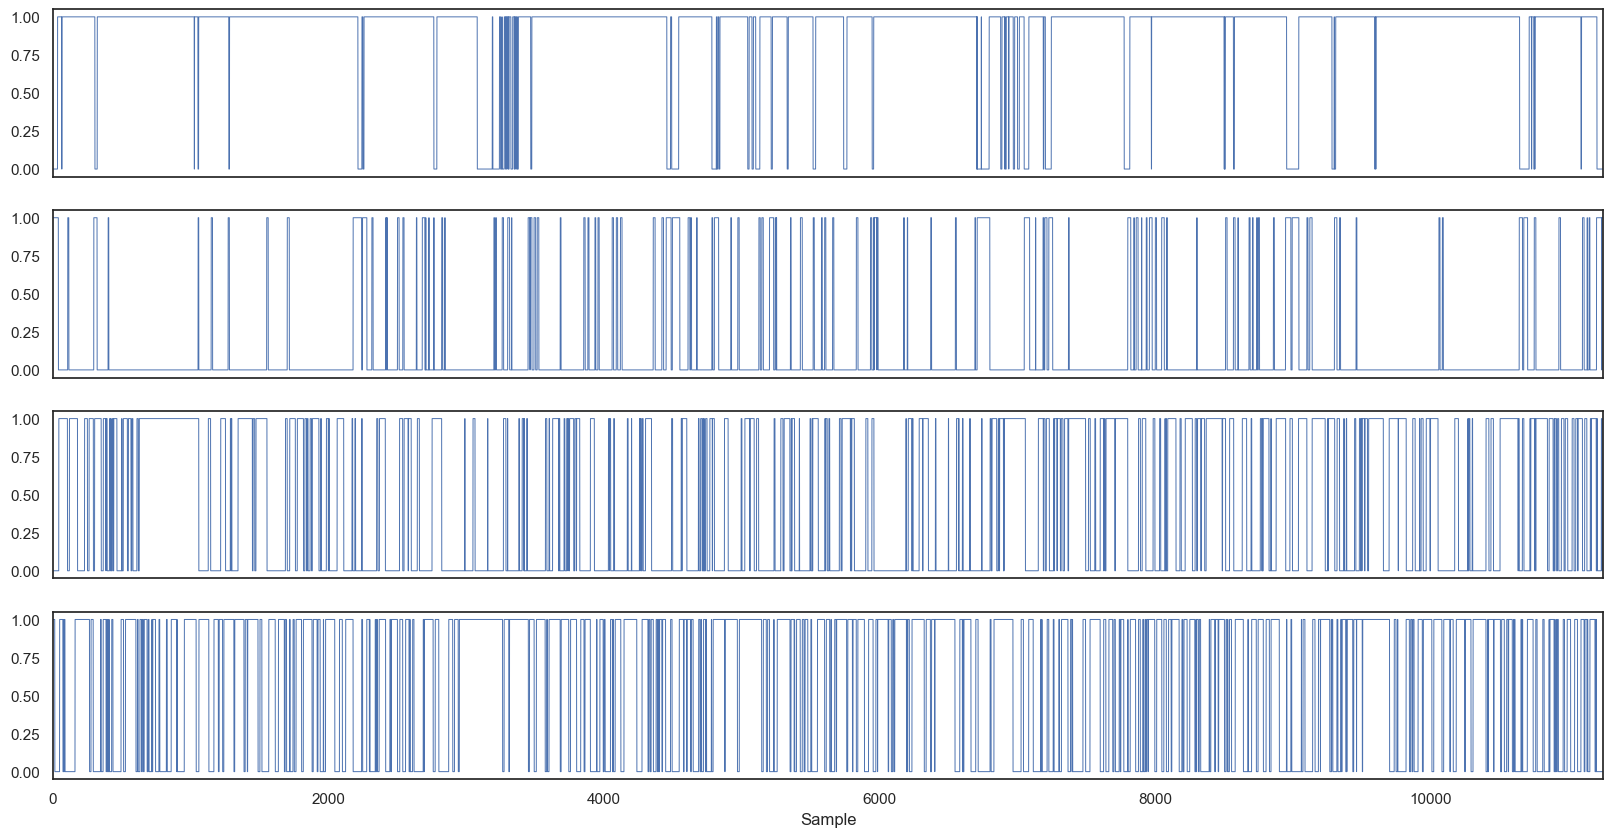

In [28]:
plotting.plot_separate_time_series(gmm_norm_alpha[1],n_samples=trial_length * sfreq * num_trials)

In [32]:
unprepared_files = sorted(glob(f"{BASE_DIR}/derivatives_1_90/*/sflip_parc-raw.fif"))
raw = modes.convert_to_mne_raw(
            gmm_norm_alpha[0],
            unprepared_files[0],
            n_embeddings=15, 
        )

Temporal domain - Plotting

In [7]:
import mne
def epoch_state_time_course(stc):
    """Get subject-specific evoked responses in the mode occupancies."""

    unprepared_files = sorted(glob(f"{BASE_DIR}/derivatives_1_90/*/sflip_parc-raw.fif"))

    # Epoch the mode time courses
    event_dict = {
        "Baseline": 1,
        "Presentation": 2,
        "Task": 3
    }

    epochs_ = []
    for s, p in zip(stc, unprepared_files):
        raw = modes.convert_to_mne_raw(
            s,
            p,
            n_embeddings=15, 
        )

        # Trial every 9s
        events = mne.make_fixed_length_events(raw, id=event_dict["Task"], start=4, duration=9)
        e = mne.Epochs(
            raw,
            events,
            event_dict["Task"],
            tmin=-3.5,
            tmax=4.5,
            verbose=True,
            baseline=None
        )

        # Baseline correct
        e_ = e.apply_baseline((-3.5,-3))
        epochs_.append(np.mean(e_.get_data(picks="misc"), axis=0).T)

    epochs = np.array(epochs_)
    t = e.times

    return t, epochs

In [29]:
# Load GMM-tresholded, baseline corrected evoked mode time courses
# t, epochs = epoch_state_time_course(gmm_norm_alpha)
# pickle.dump(epochs, open(f"{OUTPUT_DIR}/epoched_dynemo_gmm.pkl", "wb"))
epochs = pickle.load(open(f"{OUTPUT_DIR}/epoched_dynemo_gmm.pkl", "rb")) #n_subjects, n_samples, n_modes

In [ ]:
import numpy as np

# Calculate mean, std, and CV
mean_norm_alpha = np.array([np.mean(sub, axis=0) for sub in epochs])
std_norm_alpha = np.array([np.std(sub, axis=0) for sub in epochs])
cv_norm_alpha = np.array([np.std(sub, axis=0)/np.mean(sub, axis=0) for sub in epochs])

fig, ax = plotting.plot_violin(mean_norm_alpha.T, x_label="Mode", y_label="Mean alpha")
fig, ax = plotting.plot_violin(std_norm_alpha.T, x_label="Mode", y_label="Std alpha")
fig, ax = plotting.plot_violin(cv_norm_alpha.T, x_label="Mode", y_label="CV alpha")

In [5]:
import warnings

def _check_stat_assumption(samples1, samples2, ks_alpha=0.05, ev_alpha=0.05):
    """Checks normality of each sample and whether samples have an equal variance.

    Parameters
    ----------
    samples1 : np.ndarray
        Array of sample data (group 1). Shape must be (n_samples,).
    samples2 : np.ndarray
        Array of sample data (group 2). Shape must be (n_samples,).
    ks_alpha : float
        Threshold to use for null hypothesis rejection in the Kolmogorov-Smirnov test.
        Defaults to 0.05.
    ev_alpha : float
        Threshold to use for null hypothesis rejection in the equal variance test.
        This test can be the Levene's test or Bartlett's test, depending on the 
        normality of sample distributions. Defaults to 0.05.

    Returns
    -------
    nm_flag : bool
        If True, both samples follow a normal distribution.
    ev_flag : bool
        If True, two sample groups have an equal variance.
    """

    # Set flags for normality and equal variance
    nm_flag, ev_flag = True, True
    print("*** Checking Normality & Equal Variance Assumptions ***")

    # Check normality assumption
    ks_pvals = []
    for s, samples in enumerate([samples1, samples2]):
        stand_samples = stats.zscore(samples)
        res = stats.ks_1samp(stand_samples, cdf=stats.norm.cdf)
        ks_pvals.append(res.pvalue)
        print(f"\t[KS Test] p-value (Sample #{s}): {res.pvalue}")
        if res.pvalue < ks_alpha:
             print(f"\t[KS Test] Sample #{s}: Null hypothesis rejected. The data are not distributed " + 
                   "according to the standard normal distribution.")
    
    # Check equal variance assumption
    if np.sum([pval < ks_alpha for pval in ks_pvals]) != 0:
        nm_flag = False
        # Levene's test
        _, ev_pval = stats.levene(samples1, samples2)
        ev_test_name = "Levene's"
    else:
        # Bartlett's test
        _, ev_pval = stats.bartlett(samples1, samples2)
        ev_test_name = "Bartlett's"
    print(f"\t[{ev_test_name} Test] p-value: ", ev_pval)
    if ev_pval < ev_alpha:
        print(f"\t[{ev_test_name} Test] Null hypothesis rejected. The populations do not have equal variances.")
        ev_flag = False

    return nm_flag, ev_flag

def stat_ind_two_samples(samples1, samples2, alpha=0.05, bonferroni_ntest=None, test=None):
    """Performs a statistical test comparing two independent samples.

    Parameters
    ----------
    samples1 : np.ndarray
        Array of sample data (group 1). Shape must be (n_samples,).
    samples2 : np.ndarray
        Array of sample data (group 2). Shape must be (n_samples,).
    alpha : float
        Threshold to use for null hypothesis rejection. Defaults to 0.05.
    bonferroni_ntest : int
        Number of tests to be used for Bonferroni correction. Default to None.
    test : str
        Statistical test to use. Defaults to None, which automatically selects
        the test after checking the assumptions.

    Returns
    -------
    stat : float
        The test statistic. The test can be the Student's t-test, Welch's t-test, 
        or Wilcoxon Rank Sum test depending on the test assumptions.
    pval : float
        The p-value of the test.
    sig_indicator : bool
        Whether the p-value is significant or not. If bonferroni_ntest is given, 
        the p-value will be evaluated against the corrected threshold.
    """

    # Check normality and equal variance assumption
    if test is None:
        nm_flag, ev_flag = _check_stat_assumption(samples1, samples2)
    else:
        if test == "ttest":
            nm_flag, ev_flag = True, True
        elif test == "welch":
            nm_flag, ev_flag = True, False
        elif test == "wilcoxon":
            nm_flag, ev_flag = False, True

    # Compare two independent groups
    print("*** Comparing Two Independent Groups ***")
    if nm_flag and ev_flag:
        print("\tConducting the two-samples independent T-Test ...")
        stat, pval = stats.ttest_ind(samples1, samples2, equal_var=True)
    if nm_flag and not ev_flag:
        print("\tConducting the Welch's t-test ...")
        stat, pval = stats.ttest_ind(samples1, samples2, equal_var=False)
    if not nm_flag:
        print("\tConducting the Wilcoxon Rank Sum test ...")
        if not ev_flag:
            warnings.warn("Caution: Distributions have unequal variances.", UserWarning)
        stat, pval = stats.ranksums(samples1, samples2)
    print(f"\tResult: statistic={stat} | p-value={pval}")

    # Apply Bonferroni correction
    if bonferroni_ntest is not None:
        alpha /= bonferroni_ntest
    sig_indicator = pval < alpha
    print(f"[Bonferroni Correction] Threshold: {alpha}, Significance: {sig_indicator}")

    return stat, pval, sig_indicator

In [ ]:
from bonus import glm_regress_matrix

cov_stacked = np.stack((covariates.sex, covariates.TIV),axis=1)

pval_list_mean = []
pval_list_std = []
pval_list_cv = []
for mode in range(n_modes):
    print(f"T-test for the Mean covariance of Mode {mode + 1}")
    mean_resid, _, _, _ = glm_regress_matrix.glm_regress_matrix(mean_norm_alpha, cov_stacked, polynomial_fit=0)
    _, pval, _ = stat_ind_two_samples(mean_resid[young_indices,mode], 
                         mean_resid[old_indices,mode],
                         bonferroni_ntest=n_modes)
    pval_list_mean.append(pval)
    print(f"T-test for the Std of Mode {mode + 1}")
    std_resid, _, _, _ = glm_regress_matrix.glm_regress_matrix(std_norm_alpha, cov_stacked, polynomial_fit=0)
    _, pval, _ = stat_ind_two_samples(std_resid[young_indices,mode], 
                         std_resid[old_indices,mode],
                         bonferroni_ntest=n_modes)
    pval_list_std.append(pval)
    
    print(f"T-test for the CV of Mode {mode + 1}")
    cv_resid, _, _, _ = glm_regress_matrix.glm_regress_matrix(std_norm_alpha/mean_norm_alpha, cov_stacked, polynomial_fit=0)
    _, pval, _ = stat_ind_two_samples(cv_resid[young_indices,mode], 
                         cv_resid[old_indices,mode],
                         bonferroni_ntest=n_modes)
    pval_list_cv.append(pval)
    print("\n")

pvals = np.stack((pval_list_mean, pval_list_std,pval_list_cv))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from bonus.super_funcs import _categorise_pvalue

# Create a figure with 3 subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharex=True)
sns.set_theme(style='white')

# List of metric data and corresponding y-axis labels
metrics = [
    ('Mean Alpha', mean_norm_alpha),
    ('Standard Deviation', std_norm_alpha),
    ('Coefficient of Variation', cv_norm_alpha)
]


for ax_idx, (metric_name, metric_data) in enumerate(metrics):
    df_flat = pd.DataFrame({
        metric_name: metric_data.flatten(),
        'Mode': np.tile([f'Mode {i+1}' for i in range(n_modes)], len(subject_list)),
        'Group': np.repeat([age[i] for i in range(len(subject_list))], n_modes)
    })
    
    # Map group labels to actual group names
    df_flat['Group'] = df_flat['Group'].map({1: 'Young', 2: 'Old'})
    
    # Create violin plot for the current metric
    vp = sns.violinplot(
        x='Mode', y=metric_name, hue='Group', data=df_flat, ax=axs[ax_idx],
        split=True, palette={"Young": "b", "Old": "r"}, linewidth=1, inner="box",
    )
    sns.despine(fig=fig, ax=axs[ax_idx])  # Remove top and right axes
    
    # Calculate vmin and vmax for p-value annotation
    vmin, vmax = [], []
    for collection in vp.collections:
        if isinstance(collection, matplotlib.collections.PolyCollection):
            vmin.append(np.min(collection.get_paths()[0].vertices[:, 1]))
            vmax.append(np.max(collection.get_paths()[0].vertices[:, 1]))
    vmin = np.min(np.array(vmin))
    vmax = np.max(np.array(vmax))
    
    # Adjust the height for p-value annotation
    ht = (vmax - vmin) * 0.045

    # Add p-value annotations for each mode
    for mode in range(n_modes):
        p_label = _categorise_pvalue(pvals[ax_idx, mode])
        if p_label != "n.s.":  # Add annotation only for significant p-values
            axs[ax_idx].text(
                mode,  # Correct mode x-position
                vmax + ht,  # Slightly above the violin plot
                p_label, 
                ha="center", va="center",
                fontsize=12, fontweight="bold"
            )
    
    # Adjust the y-axis limits
    axs[ax_idx].set_ylim([axs[ax_idx].get_ylim()[0], axs[ax_idx].get_ylim()[1] + (vmax - vmin) * 0.25])

    # Add legend to the first plot, remove from others
    if ax_idx == 2:
        handles, labels = axs[ax_idx].get_legend_handles_labels()
        axs[ax_idx].legend(handles[:2], labels[:2], title="Age group", loc='upper right', bbox_to_anchor=(1, 1))
    else:
        axs[ax_idx].get_legend().remove()  # Remove the legend for the other subplots

# Show the plot
plt.tight_layout()
plt.show()


PLOTTING EVOKED RESPONSE

In [ ]:
from bonus.super_funcs import plot_evoked_response_with_clusters_indices

fig_full, ax_full = plt.subplots(8, 3, figsize=(12, 20))
ax_full = ax_full.flatten()

# Plot the average evoked response
ax_avg = fig_full.add_subplot(8,3,(1,3))
plot_evoked_response_with_clusters_indices(
    np.linspace(-3.5, 4.5, 2001),
    np.mean(epochs, axis=0),
    cluster_indices=None,
    labels=[f"Mode {mode + 1}" for mode in range(epochs.shape[-1])],
    x_label="Time (s)",
    y_label="Mode Probability",
    legend_loc=4,
    ax=ax_avg,
    title="Average of All Subjects",
)

# Plot young subjects
for i, name in enumerate(young_subjects):
    plot_evoked_response_with_clusters_indices(
        np.linspace(-3.5, 4.5, 2001),
        epochs[subject_list.index(name)],
        cluster_indices=None,
        labels=None,
        x_label="Time (s)",
        y_label="Mode Probability",
        ax=ax_full[i+3],
        title=f"Subject {name} (Young)",
        legend_loc=None
    )

# Plot old subjects
for i, name in enumerate(old_subjects):
    plot_evoked_response_with_clusters_indices(
        np.linspace(-3.5, 4.5, 2001),
        epochs[subject_list.index(name)],
        cluster_indices=None,
        labels=None,
        x_label="Time (s)",
        y_label="Mode Probability",
        ax=ax_full[i + 3 + len(young_subjects)],
        title=f"Subject {name} (Old)",
        legend_loc=None
    )

# Hide unused subplots
to_rm = list(range(3)) + list(range(len(subject_list) + 3, len(ax_full)))
for ax in to_rm: fig_full.delaxes(ax_full[ax])


plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/dynemo_evoked_response_with_average.png", dpi=300)